### Calibrate implied rates and dividend curves

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from vol_risk.models.linear import calib_linear_equity_market
from vol_risk.calibration.data.option_chain import OptionChain
from vol_risk.utils.calendar import Actual365Fixed
logger = logging.getLogger(__name__)
plt.style.use("ggplot")

#### Import option chain data

In [2]:
input_data_path = Path().resolve() / "data" / "test" / "CBOE_EOD_2023-08-25.csv"

# Import data
df = (
    pd.read_csv(input_data_path)
    .rename(
        columns={
            "quote_date": "anchor",
            "expiration": "expiry",
            "trade_volume": "volume",
            "bid_1545": "bid",
            "ask_1545": "ask",
        }
    )
    .assign(
        spot=lambda x: 0.5 * (x.underlying_bid_1545 + x.underlying_ask_1545),
        anchor=lambda x: pd.to_datetime(x.anchor, format="%Y-%m-%d", errors="raise"),
        expiry=lambda x: pd.to_datetime(x.expiry, format="%Y-%m-%d", errors="raise"),
        mid=lambda x: 0.5 * (x.bid + x.ask),
    )
)

#### Filter option data

In [3]:
idx = (df.underlying_symbol == "SPY") & (df["anchor"] == df["expiry"])
spot = (
    df.loc[df.underlying_symbol == "SPY", ["underlying_bid_1545", "underlying_ask_1545"]]
    .mean(axis=1)
    .drop_duplicates()
    .to_numpy()
)

df_spx = df[
    ((df.underlying_symbol == "^SPX") & (df["root"] == "SPX"))
    & (df["open_interest"].notna() & (df["open_interest"] > 10))
    & (df["bid"] > 0)
    & (df["mid"] > 0.10)
    & (df["ask"] > df["bid"])
    & ((df["ask"] - df["bid"]) / df["mid"] < 0.2)
    & (df["expiry"] - df["anchor"] >= pd.Timedelta(days=14))
    & ((df["strike"] / df["spot"]) > 0.5)
    & ((df["strike"] / df["spot"]) < 1.5)
]

spx_chain = OptionChain(df_spx, Actual365Fixed)

#### Calibrate and plot regression

Maturity 2028-12-15 00:00:00 has less than 10 observables. It will be skipped.


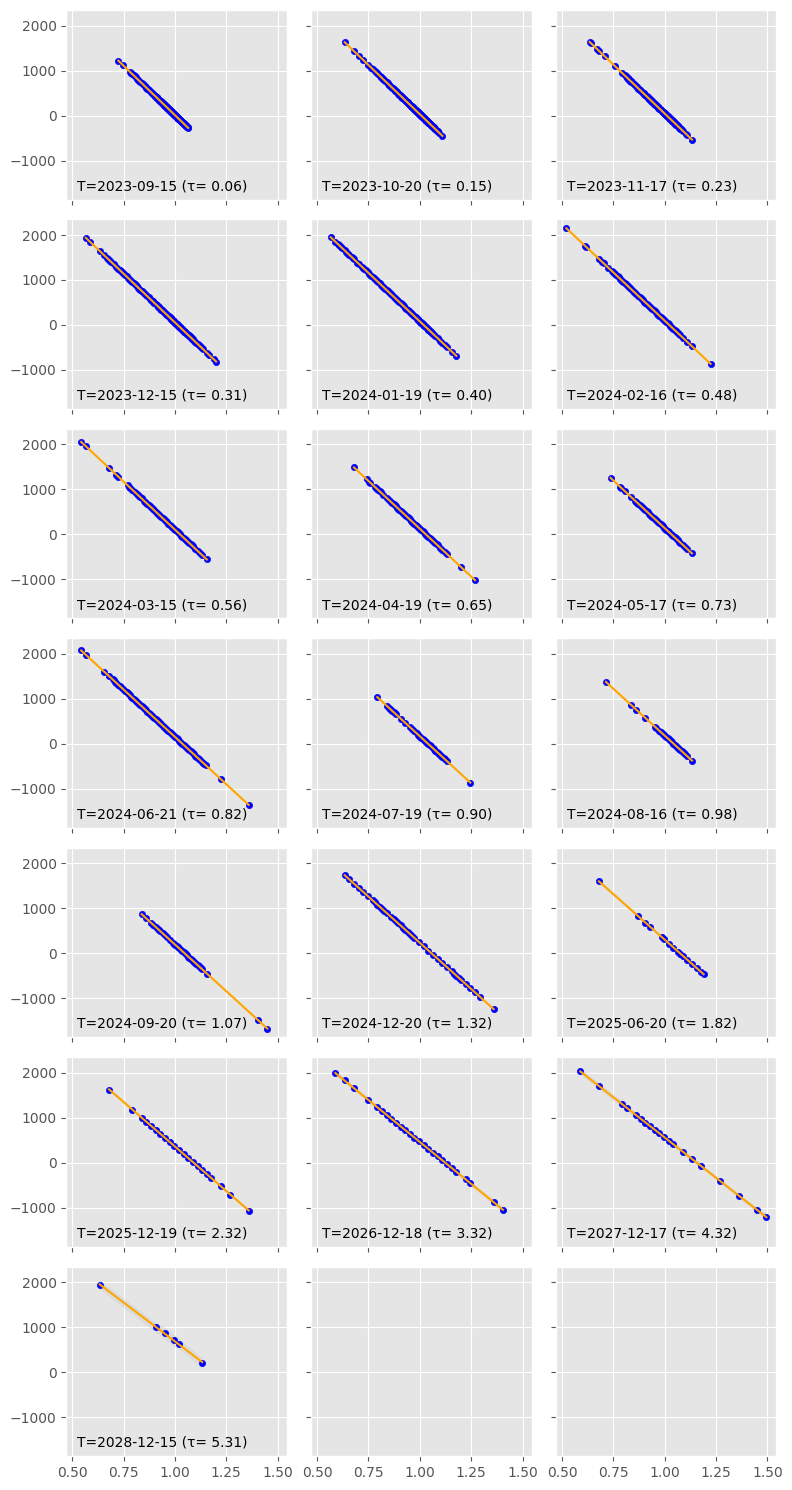

In [16]:
n = np.unique(spx_chain.expiry).size
n_col = 3
n_row = n // n_col + int(n % n_col > 0)
fig, axes = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8, 15))

model, stats = calib_linear_equity_market(spx_chain, axes=axes.flatten())

plt.tight_layout()
plt.show()
plt.close(fig)

#### Plot model output

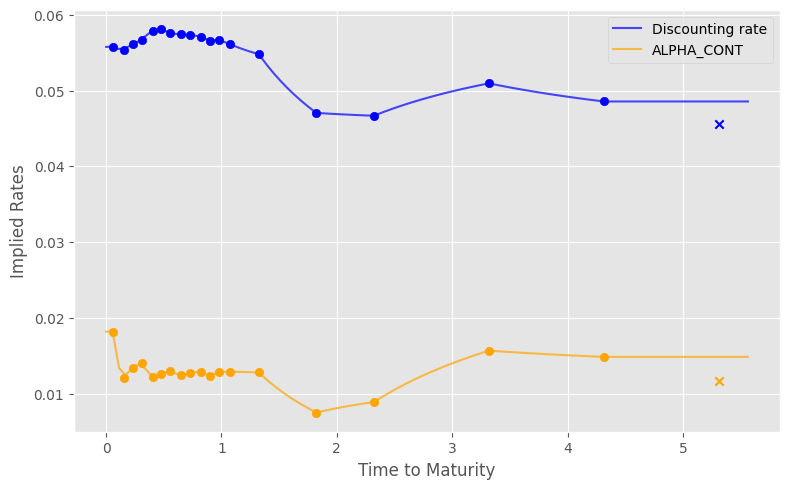

In [13]:
# plot model output
tau_granular = np.linspace(0.0001, spx_chain.tau.max() + 0.25, 100)
zero_curve_granular = model.zero_rate(tau_granular)
dvd_curve_granular = model.zero_dvd_yield(tau_granular)
fwd_price_granular = model.fwd(tau_granular)

fig, ax = plt.subplots(figsize=(8, 5))
# ax2 = ax.twinx()

ax.plot(tau_granular, zero_curve_granular, label="Discounting rate", color="blue", alpha=0.7)
ax.plot(tau_granular, dvd_curve_granular, label="ALPHA_CONT", color="orange", alpha=0.7)
# ax2.plot(tau_granular, fwd_price_granular, label="Forward Price", color="green")

# Plot calibrated points
mkt_tau = np.array([x["tau"] for x in stats.values()])
reg_params = np.array([list(x["coeff"]) for x in stats.values()])
excluded_idx = np.array([x["excluded"] for x in stats.values()])

spot = spx_chain.spot
r_mkt = -np.log(reg_params[:, 1]) / mkt_tau
q_mkt = -np.log(reg_params[:, 0] / spot) / mkt_tau

ax.scatter(mkt_tau[~excluded_idx], r_mkt[~excluded_idx], color="blue", marker="o")
ax.scatter(mkt_tau[~excluded_idx], q_mkt[~excluded_idx], color="orange", marker="o")

if any(excluded_idx):
    ax.scatter(mkt_tau[excluded_idx], r_mkt[excluded_idx], color="blue", marker="x")
    ax.scatter(mkt_tau[excluded_idx], q_mkt[excluded_idx], color="orange", marker="x")

ax.set_xlabel("Time to Maturity")
ax.set_ylabel("Implied Rates")
ax.legend(loc="upper right")
# ax2.set_ylabel("Forward Price")
# ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [6]:
excluded_idx


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

#### Print statistics    

In [7]:
pd.DataFrame(stats).T

,coeff,n_obs,in_bid_ask,tau,excluded
2023-09-15,"(4409.290501309949, 0.9967953753314813)",155,True,0.057534,False
2023-10-20,"(4405.750018411782, 0.9915333405521558)",165,True,0.153425,False
2023-11-17,"(4400.294959243463, 0.9871656668130993)",143,True,0.230137,False
2023-12-15,"(4394.997248681637, 0.9827551093277063)",135,True,0.306849,False
2024-01-19,"(4392.216178280253, 0.9769386748673257)",103,True,0.40274,False
2024-02-16,"(4387.283062321078, 0.9724932408208405)",70,True,0.479452,False
2024-03-15,"(4382.165721488722, 0.9684925148144301)",63,True,0.556164,False
2024-04-19,"(4378.370618651894, 0.9632326869806096)",60,True,0.652055,False
2024-05-17,"(4373.065894742033, 0.9590616553220872)",48,True,0.728767,False
2024-06-21,"(4367.152242130769, 0.953962331966088)",83,True,0.824658,False
